In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2022-11-03 16:38:40.210971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def inside(r1, r2):
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2
    return (x1 > x2) and (y1 > y2) and (x1 + w1 < x2 + w2) and (y1 + h1 < y2 + h2)


def wrap_digit(rect, img_w, img_h):
    x, y, w, h = rect
    x_center = x + w // 2
    y_center = y + h // 2
    if h > w:
        w = h
        x = x_center - (w // 2)
    else:
        h = w
        y = y_center - (h // 2)

    padding = 5
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    if x < 0:
        x = 0
    elif x > img_w:
        x = img_w

    if y < 0:
        y = 0
    elif y > img_h:
        y = img_h

    if x + w > img_w:
        w = img_w - x

    if y + h > img_h:
        h = img_h - y

    return x, y, w, h


In [3]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def sortBoundingBox(rectangles): 
    _,temp,_,_ = rectangles[0]
    tempArr=[]
    outArr=[]
    for r in rectangles:
        x,y,_,_ = r
        if y < temp-5 or y > temp + 5:
            tempArr.sort(key=lambda y: y[0])
            outArr.insert(0,tempArr.copy())
            tempArr.clear()
        tempArr.append(r)
        temp = y
        
    tempArr.sort(key=lambda y: y[0])
    outArr.insert(0,tempArr.copy())
    tempArr.clear()
    """for r in outArr:
        tempArr.append(r)"""
    return flatten(outArr)

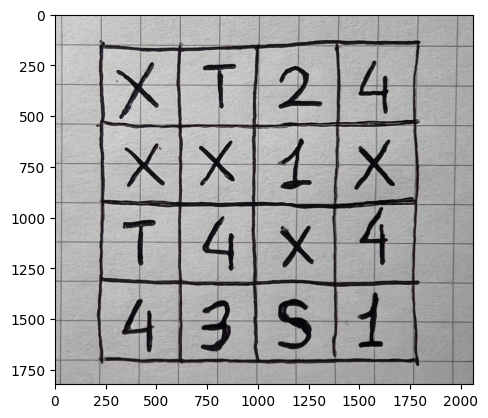

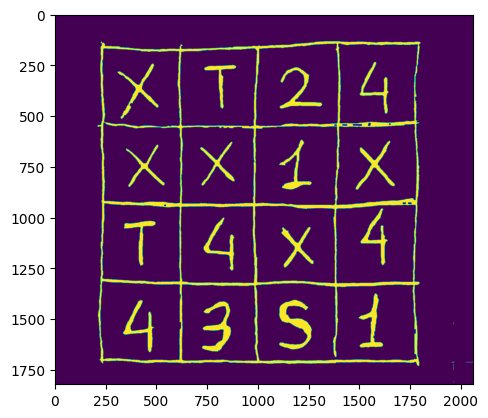

In [4]:
img_path = "./img/maze_hand.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.GaussianBlur(gray, (7, 7), 0, gray)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
erode_kernel = np.ones((2, 2), np.uint8)
thresh = cv2.erode(thresh, erode_kernel, thresh, iterations=6)
contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(img)
plt.show()
plt.imshow(thresh)
plt.show()

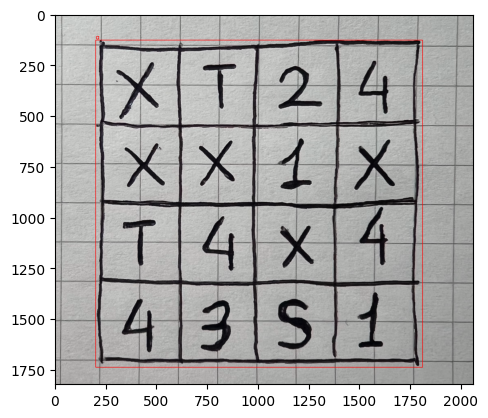

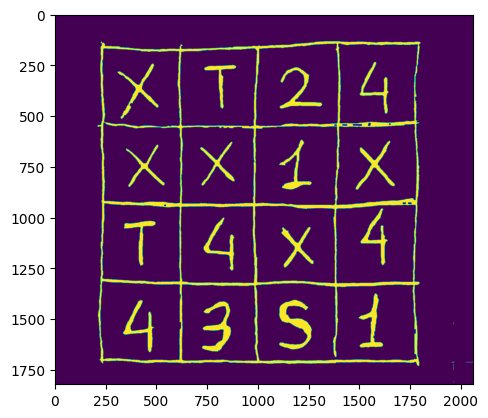

2022-11-03 16:38:59.680 Python[22935:228841] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/zf/gdlmt0zj79q8jr7ktn0gx_t80000gn/T/org.python.python.savedState


32

: 

In [6]:
rectangles = []

img_h, img_w = img.shape[:2]
img_area = img_w * img_h
for c in contours:
    a = cv2.contourArea(c)
    if a >= 0.98 * img_area or a <= 0.0001 * img_area:
        continue

    r = cv2.boundingRect(c)
    is_inside = False
    for q in rectangles:
        if inside(r, q):
            is_inside = True
            break
    if not is_inside:
        rectangles.append(r)
count = 0
rectangles = sortBoundingBox(rectangles)
for r in rectangles:
    count += 1
    x, y, w, h = wrap_digit(r, img_w, img_h)
    roi = thresh[y : y + h, x : x + w]
    
#     predictions = model.predict(roi)
#     classIndex = np.argmax(predictions, axis=-1)
    
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(
        img, "a", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2
    )

plt.imshow(img)
plt.show()
plt.imshow(thresh)
plt.show()
cv2.imwrite("detected_and_classified_digits_thresh.png", thresh)
cv2.imwrite("detected_and_classified_digits.png", img)
cv2.imshow("thresh", thresh)
cv2.imshow("detected and classified digits", img)
cv2.waitKey()